## Data Import and View Settings

In [1]:
#Import basic packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#Import model validation and preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#Import regression, metric, and regularization packages
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

#Set viewing max to 300 variables
pd.set_option('display.max_columns', 250)

#Reads in the cleaned training data
df = pd.read_csv('datasets/train_cleaned_by_mr_clean.csv')

# saving a copy of original dataframe
originale = df

In [2]:
#Removes the three extreme Price by Area outliers in the training set
df.drop(959,inplace=True)
df.drop(1882,inplace=True)
df.drop(125,inplace=True)

#Save csv with no outliers
df.to_csv('datasets/train_cleaned_by_mr_clean_no_outliers.csv',index=False)
#Load the new csv in
df = pd.read_csv('datasets/train_cleaned_by_mr_clean_no_outliers.csv')

In [3]:
# Setting X and y variables for model
y = df['SalePrice']
df.drop(['SalePrice','Id'], axis=1, inplace=True)

### Feature Engineering 

In [4]:
#These are the two polynomial features I ended up including.  I decided to just create them manually here.

#Interaction between Overall Quality and Above Ground Living Area (sq. ft)
df['Overall Qual Gr Liv Area'] = df['Overall Qual'] * df['Gr Liv Area']
#Square of Overall Quality
df['Overall Qual^2'] = df['Overall Qual'] * df['Overall Qual']

#I also engineered a feature for total bathrooms, from full baths and half baths.
df['Bathroom Total'] = df['Full Bath'] + (0.5 * df['Half Bath'])

#We now have 218 features total.
df.shape

(2045, 204)

In [5]:
#Removes the 100 features least correlated with sale price.
#Specifically, this code makes a sorted list of the magnitude of all feature correlations with sale price,
#drops the 100 smallest correlations, grabs remaining feature names, and condenses feature set to only those features.
features_keep = list(abs(df.corrwith(y)).sort_values(ascending=False)[:-100].index)
df = df[features_keep]

#This additional drop list is based on me then iteratively fitting models and removing features that 
#failed to meet a threshold for predictive influence (coefficient magnitude) after regularization.
df.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Neighborhood_dummies_Timber', 'Electrical',
        'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd',
        'Neighborhood_dummies_NAmes', 'Neighborhood_dummies_BrkSide', 'House Style_2Story', 'MS SubClass_50','Roof Style_Hip',
        'Neighborhood_dummies_Sawyer', 'Mas Vnr Type_BrkFace','MS SubClass_60','Foundation_Slab','Exterior 2nd_CmentBd',
        'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn'], axis=1,inplace=True)

In [6]:
df.shape

(2045, 84)

In [7]:
features_keep

['Overall Qual Gr Liv Area',
 'Overall Qual^2',
 'Overall Qual',
 'Gr Liv Area',
 'Exter Qual 2',
 'Exter Qual',
 'Kitchen Qual',
 'Kitchen Qual 2',
 'Total Bsmt SF',
 'Garage Area',
 '1st Flr SF',
 'Garage Cars',
 'Bsmt Qual',
 'Bathroom Total',
 'Year Built',
 'Garage Finish',
 'Garage Yr Blt',
 'Year Remod/Add',
 'Full Bath',
 'Foundation_PConc',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'Neighborhood_dummies_NridgHt',
 'BsmtFin SF 1',
 'Heating QC',
 'Bsmt Exposure',
 'Garage Type_Detchd',
 'Sale Type_New',
 'BsmtFin Type 1',
 'Garage Type_Attchd',
 'MS SubClass_60',
 'Foundation_CBlock',
 'Exterior 1st_VinylSd',
 'Exterior 2nd_VinylSd',
 'Open Porch SF',
 'Wood Deck SF',
 'Mas Vnr Type_Stone',
 'Lot Area',
 'Lot Shape',
 'Paved Drive',
 'Bsmt Full Bath',
 'Half Bath',
 'MS Zoning_RM',
 'Central Air_Y',
 'Garage Qual',
 'Roof Style_Hip',
 'Neighborhood_dummies_NoRidge',
 'Mas Vnr Type_BrkFace',
 'Neighborhood_dummies_StoneBr',
 'PID',
 'Garage Cond',
 'Roof Style_Gable',
 

In [8]:
features_keep.remove('Condition 2_PosN')

## Model Preparation 

In [9]:
#Train test split (Random state is set for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=420)

#Standardize data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

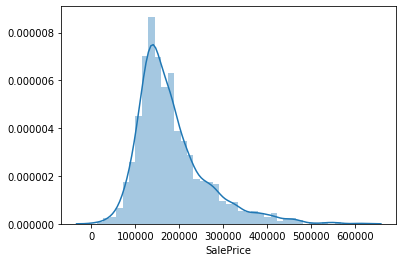

In [10]:
sns.distplot(y_train);

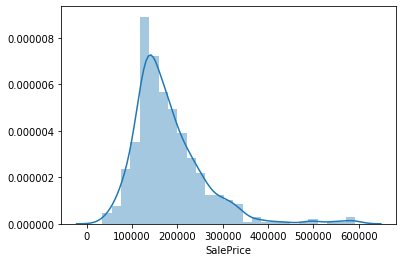

In [11]:
sns.distplot(y_test);

## Modeling 

### Baseline Model 

#### Linear Regression

In [12]:
# instantiate
lr = LinearRegression()

# fit 
lr.fit(X_train, y_train)

# Train score 
lr.score(X_train, y_train)

# Test score 
lr.score(X_test, y_test)

# Cross val score
cross_val_score(lr, X_train, y_train).mean()

0.9332470428715911

#### Grid Search with ElasticNet 

In [13]:
#Specify desired values to try for each hyperparameter
param_grid_1 = {
    'alpha':[.1,.3,.5,1,5],
    'l1_ratio':[0,.3,.5,.7,1]
}

#Instantiate GridSearchCV with ElasticNet, the parameter values, and 5-fold CV.
gs = GridSearchCV(ElasticNet(),param_grid_1,cv=5,verbose=1)

#Fitting with the scaled X_train and the transformed y_train
gs.fit(X_train_sc,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277219008026.93744, tolerance: 748709841.7503442
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305137257427.0287, tolerance: 783783165.3903155
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312118346142.64294, tolerance: 786165179.0818503
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objecti

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603289596037.6412, tolerance: 771147543.7932006
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 582399887314.045, tolerance: 751599721.849778
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18668940286.190857, tolerance: 748709841.7503442
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.3, 0.5, 1, 5],
                         'l1_ratio': [0, 0.3, 0.5, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [14]:
#Returns the best parameters
gs.best_params_

{'alpha': 5, 'l1_ratio': 1}

In [15]:
#Returns the R2 score of the best parameters
gs.best_score_

0.9333519169869644

In [16]:
gs.score(X_test_sc,y_test)

0.9194034635514323

In [17]:
#creates table of all feature variables and their model coefficients
coef_table = pd.DataFrame(gs.best_estimator_.coef_, index=X_train.columns, columns=['Coefficients'])
#creates column with coefficient magnitudes
coef_table['Magnitude']=abs(coef_table['Coefficients'])
#sorts features by coefficient magnitude (i.e.; predictive power) and shows top 25 most influential features
coef_table.sort_values('Magnitude',ascending=False).head(25)['Coefficients']

Overall Qual Gr Liv Area        48952.194757
Overall Qual                   -27992.833612
Overall Qual^2                  18993.121528
Gr Liv Area                    -15244.669868
Kitchen Qual                     9913.604163
1st Flr SF                       9183.275352
Exter Qual                       9132.035286
Total Bsmt SF                    8284.254282
Year Built                       7860.297924
BsmtFin SF 1                     7446.658834
Overall Cond                     6477.657031
Garage Type_None                 6445.347631
2nd Flr SF                       5987.923976
Kitchen Qual 2                  -5507.532295
Neighborhood_dummies_NridgHt     5184.751765
MS Zoning_RL                     4908.736666
Exter Qual 2                    -4617.493035
Neighborhood_dummies_StoneBr     4424.487197
Lot Area                         4186.104623
Functional                      -3682.631811
MS Zoning_RM                     3647.533271
Neighborhood_dummies_Somerst     3498.529124
Exterior 1

### Model Selection 

### Model Evaluation

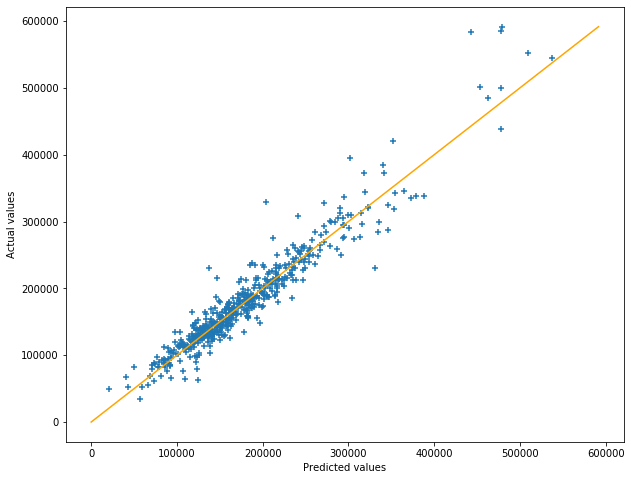

In [18]:
#Generates a list of the model's predictions for the test bloc
preds = gs.predict(X_test_sc)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(preds, y_test, marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'orange');

In [19]:
#Initializes model for whole training set
gs_full_trainset = gs.best_estimator_
#Applies StandardScaler normalization to whole training set
X_sc = ss.fit_transform(df)

#Re-fits the model
gs_full_trainset.fit(X_sc, y)
#Scores the model (training score only, of course)
gs_full_trainset.score(X_sc, y)

0.9381847800011716

## Kaggle Submission 

In [20]:
df.shape

(2045, 84)

In [22]:
#Load in the Kaggle test set with cleaning changes applied
test = pd.read_csv('datasets/test_cleaned_by_mr_clean.csv')

#Drops Id column like we did earlier to the training set.  
#Recall that there is no SalePrice info in the test set.
test.drop('Id',axis=1,inplace=True)

#Apply feature engineering changes to test set (This layout allows easy iterative manipulation)
def apply_changes_test(df):
    df['Overall Qual Gr Liv Area'] = df['Overall Qual'] * df['Gr Liv Area']
    df['Overall Qual^2'] = df['Overall Qual'] * df['Overall Qual']
    df['Bathroom Total'] = df['Full Bath'] + (0.5 * df['Half Bath'])

apply_changes_test(test)

#Apply feature elimination changes to test set
test = test[features_keep]
test.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Electrical',
            'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd', 'Neighborhood_dummies_Sawyer',
            'House Style_2Story', 'MS SubClass_50','Roof Style_Hip', 
            'Mas Vnr Type_BrkFace','MS SubClass_60','Foundation_Slab','Exterior 2nd_CmentBd',
            'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn',
            'Neighborhood_dummies_BrkSide','Neighborhood_dummies_NAmes'], axis=1,inplace=True)

# common_cols = [columns for columns in set(test.columns).intersection(df.columns)]
# test = test[common_cols]

#Scale test set
test_sc = ss.transform(test)

#Generate model predictions for test set
predictions = gs_full_trainset.predict(test_sc)

#Create submission csv in proper format
test['SalePrice'] = predictions
testfile = pd.read_csv('datasets/test_cleaned_by_mr_clean.csv')
test['Id'] = testfile['Id']
submission = test[['Id','SalePrice']]
submission.to_csv('./datasets/kaggle_submission.csv',index=False)

#View submission
submission.head()

,Id,SalePrice
0,2658,139631.487556
1,2718,120810.537682
2,2414,184868.304531
3,1989,78287.694693
4,625,157171.376775


In [ ]:
df.shape

In [ ]:
test.info()

## Conclusion and Recommendations

## References 